In [6]:
%matplotlib widget

In [1]:
# from ipywidgets import *
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('TkAgg')
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

import mne

In [2]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file C:\Users\isaco\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [3]:
#choose channels
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 14 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [4]:
#not important - renaming
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

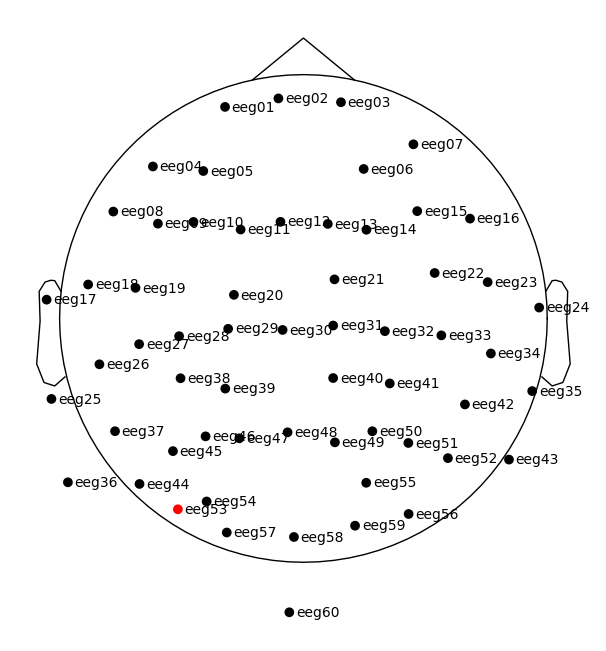

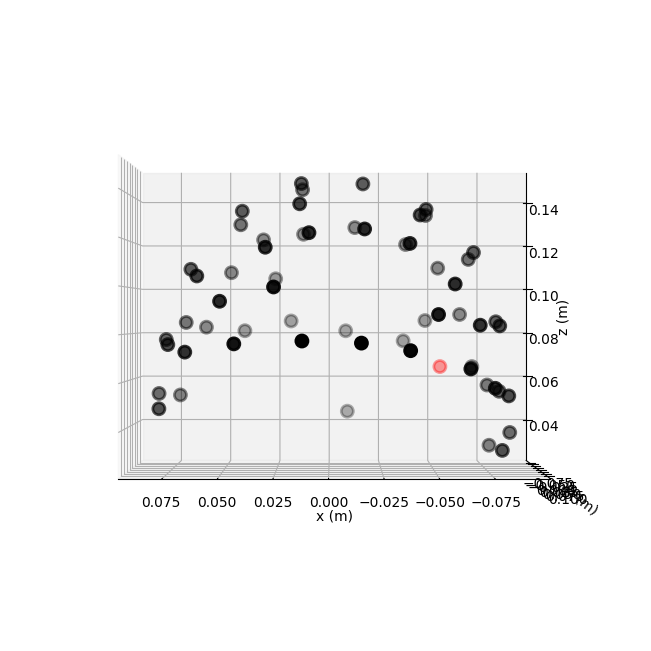

In [5]:
#show channel locations
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

Using matplotlib as 2D backend.


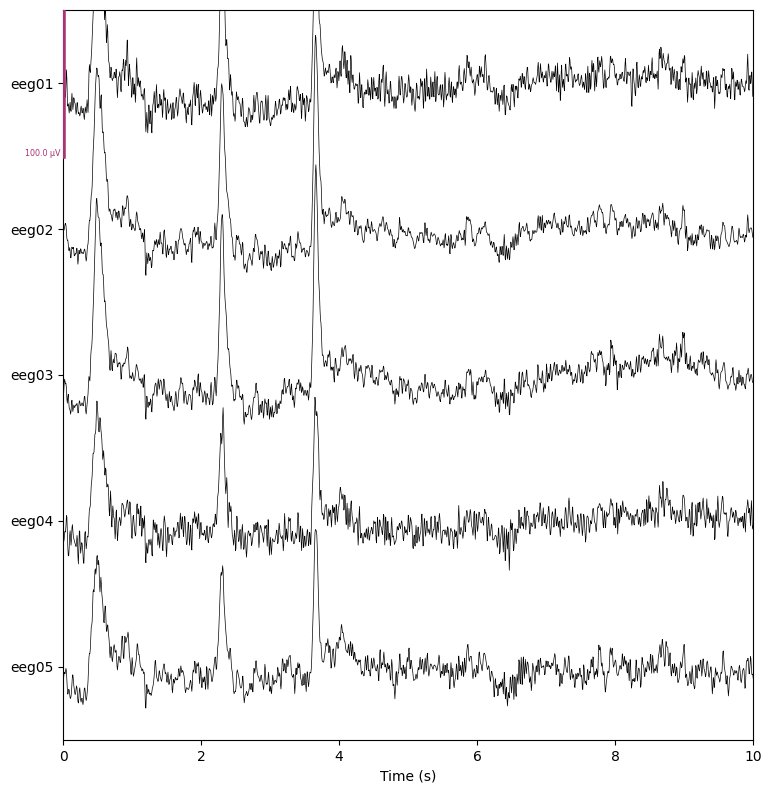

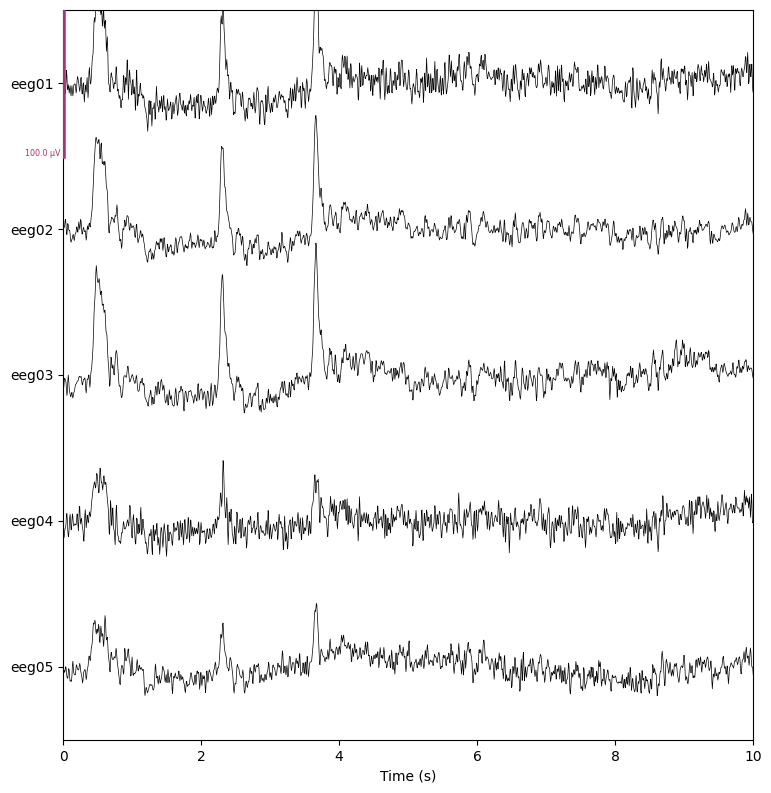

In [6]:
#see what it looked like before setting reference
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=False
        )
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

In [7]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MB, data loaded>

In [8]:
#events codes
np.unique(events[:, -1])

array([ 1,  2,  3,  4,  5, 32])

Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


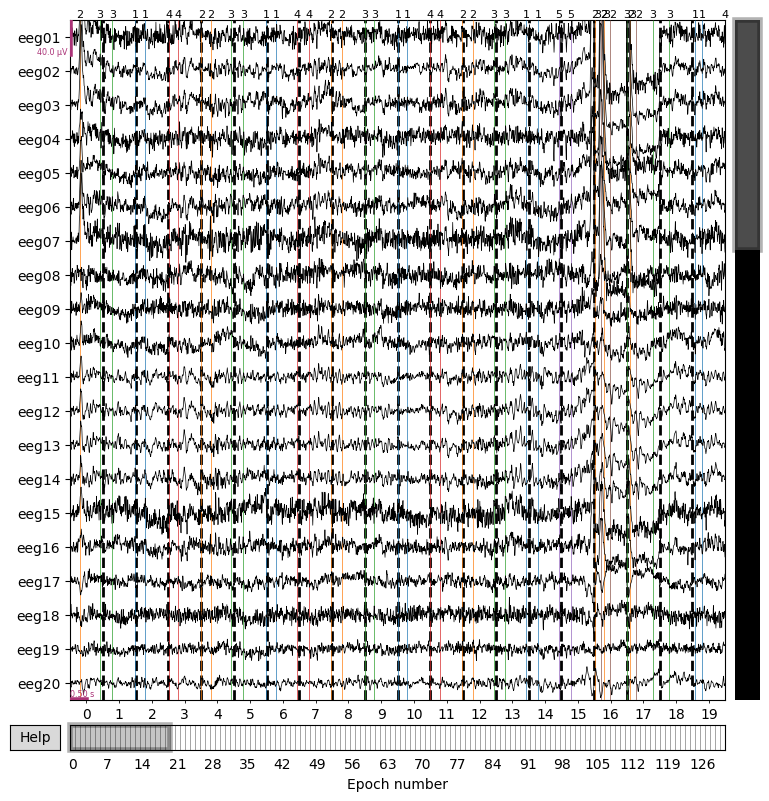

In [9]:
# rename events and construct epochs using intervals around each time event
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

In [10]:
#reject epochs if a channel amplitude exceeds max value
reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg25']
    Rejecting  epoch based on EEG : ['e

<Epochs | 114 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~10.9 MB, data loaded,
 'auditory/left': 25
 'auditory/right': 27
 'visual/left': 28
 'visual/right': 25
 'face': 5
 'buttonpress': 4>

In [11]:
#get the evoked responses we care about by filtering events and averaging epochs
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

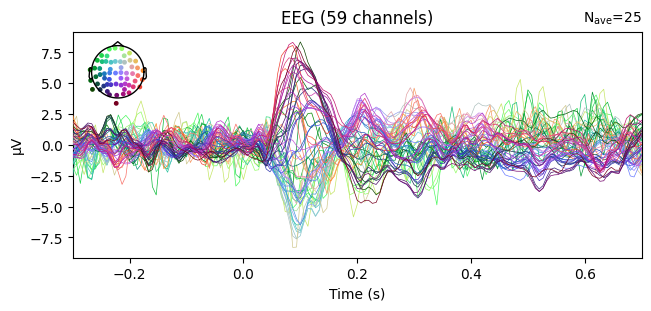

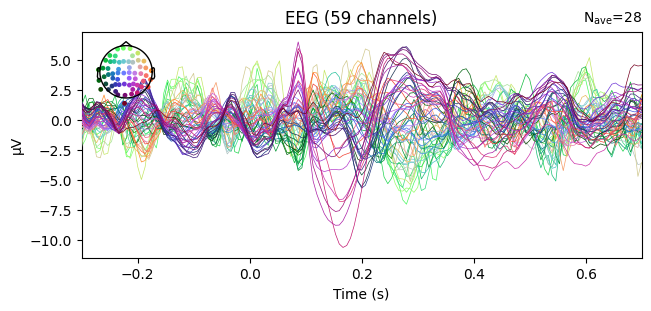

In [12]:
fig1 = l_aud.plot();
fig2 = l_vis.plot(spatial_colors=True);

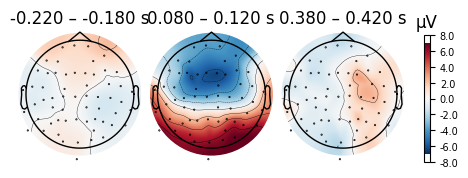

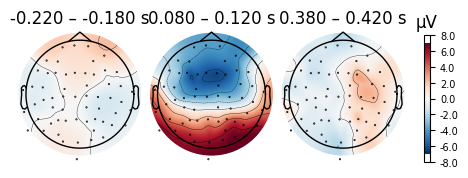

In [13]:
#display topomaps of the average evoked potential in 50 ms time windows centered at -200 ms, 100 ms, and 400 ms.
l_aud.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05)

Projections have already been applied. Setting proj attribute to True.


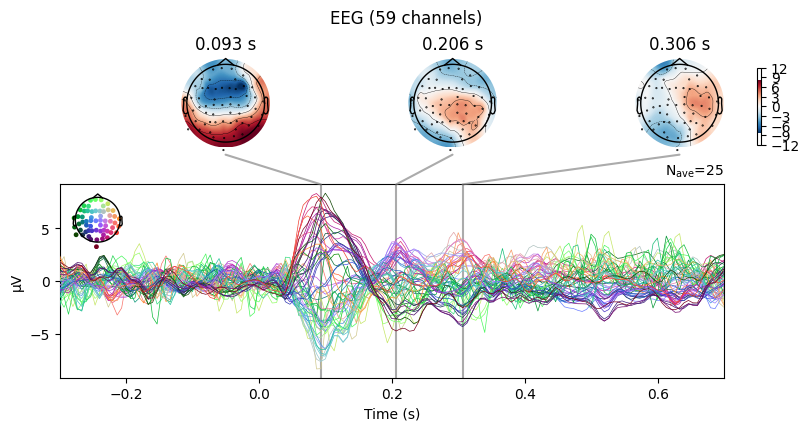

In [14]:
#see topomapson peak points together with butterflies plots 
l_aud.plot_joint();

In [35]:
def segment(ts, npeaks=3):
    #minima
    min_idx = argrelextrema(ts, np.less)

    #peaks - choose 3 of them 
    max_idx = argrelextrema(gfp, np.greater) #all peak candidates idx
    max_idx = np.argsort(ts)[np.isin(np.argsort(ts), max_idx)] #peaks idx sorted by ts value - the first one has the lowest ts value amongst the peak candidates 
    max_idx = max_idx[-npeaks:] #select how many peaks to consider 
    max_idx.sort() #sort by ascending index 

    #identify minima repair for each interval [begin,peak[ , [peak,peak[, [peak,end[
    min_repair_list = []
    cut_point_list = []
    id_left = 0
    for peak_id in max_idx:
        #locate local minima within peaks intervals - ""min_repair" is their mean value
        min_repair = (ts[id_left:peak_id][np.isin(np.arange(id_left,peak_id), min_idx)]).mean()
        min_repair_list.append(min_repair)

        #identify, for each peak value at the right, the closest minima id at its left that is less than minima repair
        #(cut at the time series index where its value at left of the peak is less than min_repair)
        cut_point = np.where(ts[id_left:peak_id]<=min_repair)[0][-1] + id_left #"+id_left" is to adjust the time series subinterval id to global time series id
        cut_point_list.append(cut_point)

        #iterate the pointer
        id_left = peak_id
        
    #last cut point should be defined at the right of the last peak
    min_repair = (ts[id_left:][np.isin(np.arange(id_left,len(ts)), min_idx)]).mean()
    cut_point = np.where(ts[id_left:]<=min_repair)[0][0] + id_left
    cut_point_list.append(cut_point)
    
    return max_idx, np.array(cut_point_list)

In [84]:
def img_idx_plot(cut_points, len_max, num_spatial_patterns = 4):
    #num_spatial_pattern per interval
    
    img_idx = [0]
    left_id = 0
    for cut_id in (list(cut_points)+[len_max-1]):
        img_idx_section = [int(np.floor((cut_id-left_id)*(i+1)/num_spatial_patterns)) + left_id for i in range(num_spatial_patterns)]
        # img_idx_section.append(cut_id) #plot above each peak as well
        img_idx = img_idx + img_idx_section
        left_id = cut_id
    
    img_idx = np.array(img_idx)
    return img_idx



In [85]:
img_idx = img_idx_plot(cut_points, len(gfp), num_spat_pat)

img_idx

array([  0,  12,  24,  36,  48,  53,  59,  65,  71,  74,  78,  82,  86,
        89,  92,  95,  99, 111, 124, 137, 150], dtype=int64)

id_left:  91
min_repair:  1.1329250631210443e-06
ts[id_left:]
ts[id_left:]<=min_repair:  [False False False False False False False False  True  True  True  True
 False False  True False False False False False False False False False
 False False False False False False False False False False False  True
  True False False False False False  True False False False False False
 False False False  True  True  True  True  True False False False False]
np.where(ts[id_left:]<=min_repair)[0]:  [ 8  9 10 11 14 35 36 42 51 52 53 54 55]


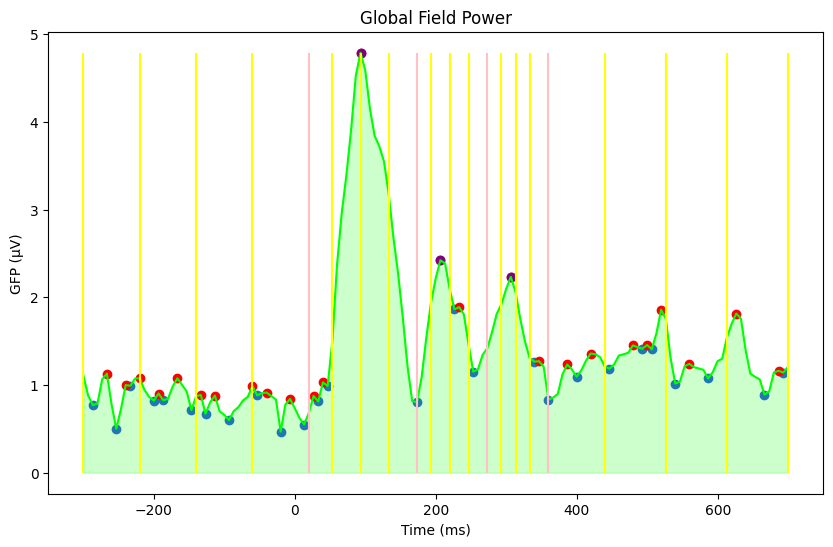

In [86]:
# Calculate Global Field Power
gfp = l_aud.data.std(axis=0, ddof=0)

min_idx = argrelextrema(gfp, np.less)
max_idx = argrelextrema(gfp, np.greater)

peak_idx, cut_points = segment(gfp, npeaks=3)

num_spat_pat = 4 #number of spatial patterns to plot (including cut point at right)
img_idx = img_idx_plot(cut_points, len(gfp), num_spat_pat)

# Visualize GFP
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(l_aud.times * 1000, gfp * 1e6, color="lime")
ax.fill_between(l_aud.times * 1000, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (ms)", ylabel="GFP (µV)", title="Global Field Power")
ax.scatter(l_aud.times[min_idx[0]]*1000, gfp[min_idx[0]]* 1e6, label="minima")
ax.scatter(l_aud.times[max_idx[0]]*1000, gfp[max_idx[0]]* 1e6, label="minima", color = "r")
ax.scatter(l_aud.times[peak_idx]*1000, gfp[peak_idx]* 1e6, label="peaks", color = "purple")
ax.vlines(l_aud.times[img_idx]*1000,0, gfp.max()*1e6, label="img_idx", color = "yellow")
ax.vlines(l_aud.times[cut_points]*1000,0, gfp.max()*1e6, label="minima", color = "pink")

# ax.scatter(l_aud.times[min_repair]*1000, gfp[min_repair]* 1e6, label="minima", color = "pink")

There are 5 sections to be visualized (up to sec=4)


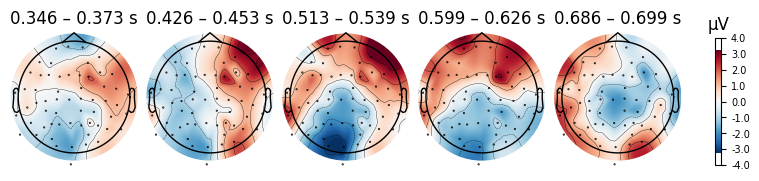

In [133]:
#display topomaps of the average evoked potential in 20 ms time windows centered at -200 ms, 100 ms, and 400 ms.
print("There are {} sections to be visualized (up to sec={})".format(len(cut_points)+1,len(cut_points)))
sec_num = 4
l_aud.plot_topomap(times= l_aud.times[img_idx[sec_num*num_spat_pat:sec_num*num_spat_pat+num_spat_pat+1]], average=0.03); #space between each samples is of 6,668ms

Projections have already been applied. Setting proj attribute to True.


C:\Users\isaco\venv_dummy\Lib\site-packages\mne\viz\evoked.py:235: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  axis.get_figure().canvas.draw()


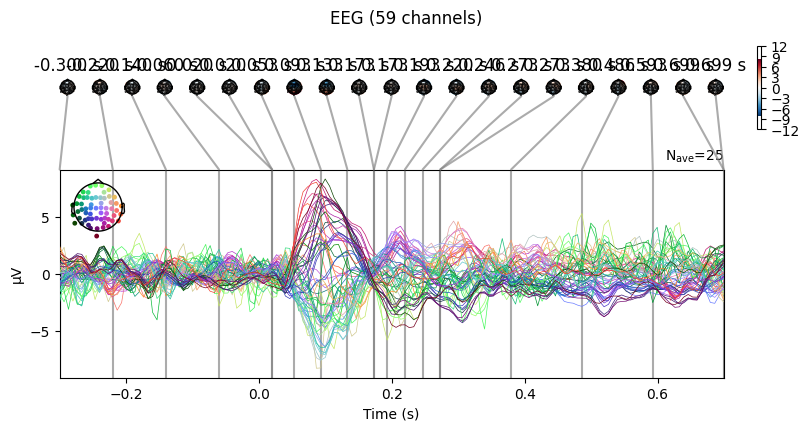

In [20]:
l_aud.plot_joint(times = l_aud.times[img_idx]);

In [22]:
# print("id_left: ", id_left)
# print("peak_id", peak_id)
# print("ts[id_left:peak_id]: ",ts[id_left:peak_id])
# print("allowed ts[id_left:peak_id]: ",ts[id_left:peak_id][np.isin(np.arange(id_left,peak_id), min_idx)])
# print("min_repair: ", min_repair)
# print("ts[id_left:peak_id]<=min_repair: ", ts[id_left:peak_id]<=min_repair)
# print("np.where(ts[id_left:peak_id]<=min_repair)[0]: ", np.where(ts[id_left:peak_id]<=min_repair)[0])
# print("np.where(ts[id_left:peak_id]<=min_repair)[0][-1]: (cutpoint id)", np.where(ts[id_left:peak_id]<=min_repair)[0][-1])